# Dota 2 Demo Merging

In [1]:
import json
import math
import os
import pickle
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

import numpy as np

from sklearn.cluster import KMeans
import time

from deepq import StatePreprocessor
from dotaenv.codes import SHAPER_STATE_PROJECT, SHAPER_STATE_DIM, STATE_DIM, ACTIONS_TOTAL
from deepq.reward_shaper import ActionAdviceRewardShaper

In [2]:
reward_shaper = ActionAdviceRewardShaper(
    replay_dir=os.path.join('..', 'completed-observations'),
    max_timesteps=500000,
    max_demos_to_load=1000)

In [3]:
reward_shaper.load()

Loaded demo from ../completed-observations/3864607992_2017020338.obs. Its length is 1702
Loaded demo from ../completed-observations/3869628336_1795613881.obs. Its length is 2213
Loaded demo from ../completed-observations/3842821829_57016936.obs. Its length is 1263
Loaded demo from ../completed-observations/3876414550_228944172.obs. Its length is 2217
Loaded demo from ../completed-observations/3889218946_1965255703.obs. Its length is 2697
Loaded demo from ../completed-observations/3850856186_1227732859.obs. Its length is 1425
Loaded demo from ../completed-observations/3840993392_1881039262.obs. Its length is 1808
Loaded demo from ../completed-observations/3864591156_39207677.obs. Its length is 1544
Loaded demo from ../completed-observations/3864651175_1372332617.obs. Its length is 1153
Loaded demo from ../completed-observations/3862003411_1481507781.obs. Its length is 4015
Loaded demo from ../completed-observations/3854509798_297786270.obs. Its length is 1422
Loaded demo from ../complet

Loaded demo from ../completed-observations/3843593640_663989996.obs. Its length is 1078
Loaded demo from ../completed-observations/3889441905_1726406333.obs. Its length is 1549
Loaded demo from ../completed-observations/3852046467_875816400.obs. Its length is 1978
Loaded demo from ../completed-observations/3869573616_2091066285.obs. Its length is 1572
Loaded demo from ../completed-observations/3852444174_1644711309.obs. Its length is 748
Loaded demo from ../completed-observations/3850858176_615431568.obs. Its length is 1531
Loaded demo from ../completed-observations/3851564805_1061998027.obs. Its length is 1641
Loaded demo from ../completed-observations/3876594693_1160510682.obs. Its length is 2827
Loaded demo from ../completed-observations/3876617739_184899114.obs. Its length is 1477
Loaded demo from ../completed-observations/3852053596_735377337.obs. Its length is 1678
Loaded demo from ../completed-observations/3851000222_1171706198.obs. Its length is 1741
Loaded demo from ../complet

Loaded demo from ../completed-observations/3842437777_154271963.obs. Its length is 1451
Loaded demo from ../completed-observations/3889282622_1712780249.obs. Its length is 3166
Loaded demo from ../completed-observations/3849614858_1580245198.obs. Its length is 963
Loaded demo from ../completed-observations/3889300894_508853461.obs. Its length is 2014
Loaded demo from ../completed-observations/3876712238_1422954320.obs. Its length is 1278
Loaded demo from ../completed-observations/3851021375_248859525.obs. Its length is 1418
Loaded demo from ../completed-observations/3862477531_346901793.obs. Its length is 1309
Loaded demo from ../completed-observations/3851915899_1720079793.obs. Its length is 1250
Loaded demo from ../completed-observations/3861376173_593056076.obs. Its length is 960
Loaded demo from ../completed-observations/3875547171_613479530.obs. Its length is 1365
Loaded demo from ../completed-observations/3840956427_275462981.obs. Its length is 1300
Loaded demo from ../completed-

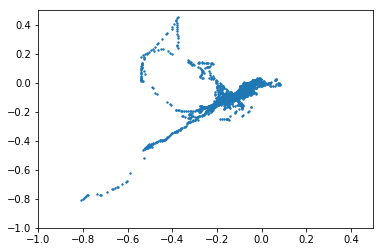

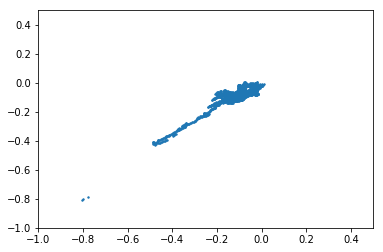

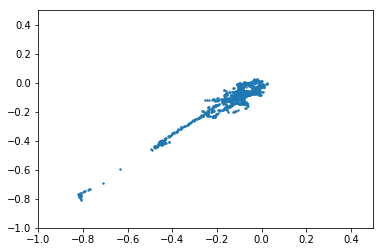

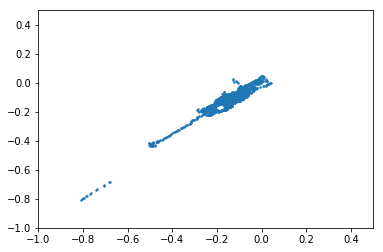

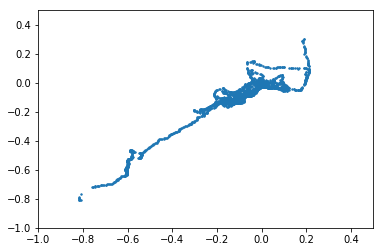

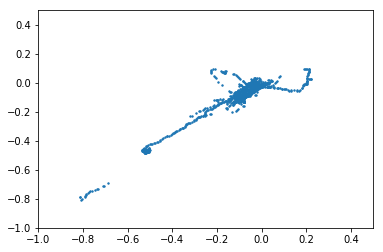

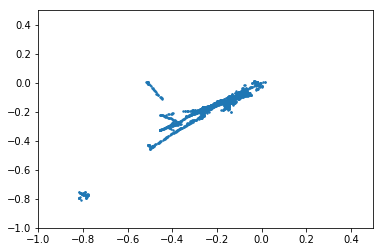

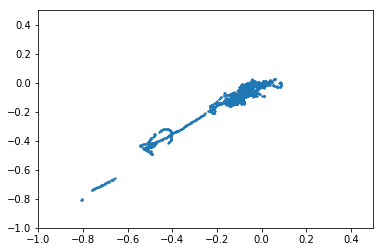

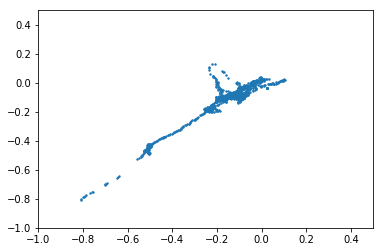

In [17]:
def plot_demo(demo):
    xs, ys = [], []
    for state, action in demo:
        x, y = state[1:3]
        xs.append(x)
        ys.append(y)
    plt.scatter(xs, ys, s=2)
    plt.axis([-1.0, 0.5, -1.0, 0.5])
    plt.show()

for i in range(1, 10):
    plot_demo(reward_shaper.demos[i])

In [4]:
states = []
actions = []
for ind, demo in enumerate(reward_shaper.demos):
    for demo_state, demo_action in demo:
        states.append(demo_state)
        actions.append(demo_action)
states = np.array(states)
print(f'Clustering has started at {time.ctime(time.time())}')
N = 1700
kmeans = KMeans(n_clusters=N, random_state=5444, n_jobs=-1).fit(states)
print(f'Clustering is done at {time.ctime(time.time())}')

Clustering has started at Sat Apr 27 01:17:47 2019
Clustering is done. Time taken: 15038.53039598465


In [6]:
cluster_demo = []
total_adviced_actions = np.zeros(ACTIONS_TOTAL, dtype=np.int)
np.set_printoptions(precision=2, suppress=True)
for i in range(N):
    center = kmeans.cluster_centers_[i]
    is_in_the_cluster = (kmeans.labels_ == i)
    cnt = np.count_nonzero(is_in_the_cluster)
    action_cnt = np.zeros(ACTIONS_TOTAL, dtype=np.int)
    indexes = np.argwhere(is_in_the_cluster).flatten()
    for ind in indexes:
        action_cnt[actions[ind]] += 1
    adviced_action = np.argmax(action_cnt)
    total_adviced_actions[adviced_action] += 1
    if False:
        print(f'CLUSTER #{i}')
        print('center:', center)
        print('contains:', cnt)
        print('action distribution:', action_cnt)
        print('most often action:', adviced_action)
    cluster_demo.append((center, adviced_action))
print('TOTAL ACTIONS:', ACTIONS_TOTAL)
print(total_adviced_actions)

TOTAL ACTIONS: 11
[133 522  49  46 174 433  51  73   0 157  62]


In [10]:
cluster_dump_file = 'cluster-1700.obs'
with open(cluster_dump_file, 'wb') as fout:
    pickle.dump(cluster_demo, fout)